In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = yf.download('GOOGL', start='2015-01-01', end='2020-01-01')

/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/compare-multiple-backtests-f1m3Q6xX-py3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [3]:
df["Close"][-1] / df["Close"][0]

/var/folders/h1/rvjbcw3x19dcwnv6qxb4pxrm0000gn/T/ipykernel_73856/2800891224.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["Close"][-1] / df["Close"][0]


2.5292982859039683

In [4]:
df["Market Returns"] = df["Close"].pct_change()

In [5]:
df.dropna(inplace=True)

<Axes: >

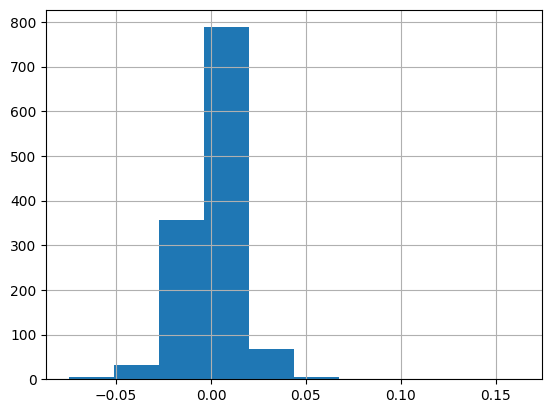

In [6]:
df["Market Returns"].hist()

In [7]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [8]:
def create_dataset(dataset, time_steps=1):
    X_data, y_data = [], []
    for i in range(len(dataset)-time_steps-1):
        X_data.append(dataset[i:(i+time_steps), 0])
        y_data.append(dataset[i + time_steps, 0])
    return np.array(X_data), np.array(y_data)

In [37]:
time_steps = 5
X_train, y_train = create_dataset(df_scaled, time_steps)

# Reshape the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [38]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/compare-multiple-backtests-f1m3Q6xX-py3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3735
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1104
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0510
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0474
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0446
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0430
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0426
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0390
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0397
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0402
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0383
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0409
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0413
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0397
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0389
Epoch 16/50
20/20 ━

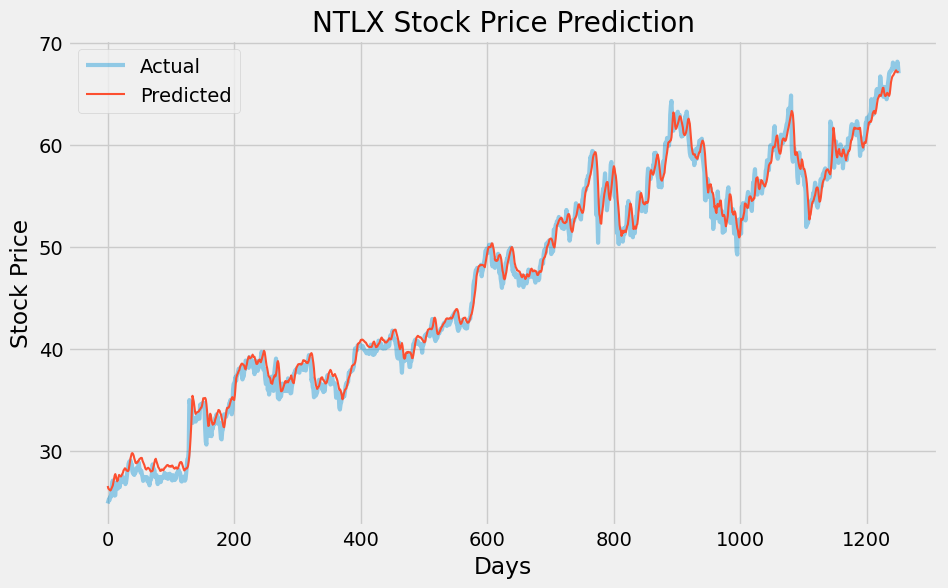

In [39]:
model.fit(X_train, y_train, epochs=50, batch_size=64,  verbose=1)

# Make predictions
y_pred = model.predict(X_train)

# Inverse transform the predicted and actual values
y_pred = scaler.inverse_transform(y_pred)
y_train = y_train.reshape(y_pred.shape[0], 1)
y_train = scaler.inverse_transform(y_train)

# Evaluate the model
mse = mean_squared_error(y_train, y_pred)
msle = mean_squared_log_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print('MSE: ', mse)
print('MSLE: ', msle)
print('MAE: ', mae)
print('R-squared: ', r2)

# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.style.use('fivethirtyeight')
plt.plot(y_train, label='Actual', linewidth = 3, alpha = 0.4)
plt.plot(y_pred, label='Predicted', linewidth = 1.5)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('NTLX Stock Price Prediction')
plt.legend()
plt.show()

In [40]:
df["Predicted_Close"] = [np.nan] * 6 + y_pred.flatten().tolist()

In [41]:
df["Predicted_Returns"] = df["Predicted_Close"].pct_change()

In [42]:
df["Predicted_Returns"].describe()

count    1250.000000
mean        0.000765
std         0.006936
min        -0.031757
25%        -0.002835
50%         0.001040
75%         0.004699
max         0.046782
Name: Predicted_Returns, dtype: float64

In [43]:
import math
from termcolor import colored as cl

In [44]:
df = df.reset_index()

In [51]:
def implement_strategy(df, investment):

    in_position = False
    equity = investment

    for i in range(1, len(df)):
        if (
            df["Predicted_Returns"][i] > 0.001
            and in_position == False
        ):
            no_of_shares = math.floor(equity / df.Close[i])
            equity -= no_of_shares * df.Close[i]
            in_position = True
            print(
                cl("BUY: ", color="green", attrs=["bold"]),
                f'{no_of_shares} Shares are bought at ${df.Close[i]} on {str(df["Date"][i])[:10]}',
            )
        elif (
            df["Predicted_Returns"][i] < -0.015
            and in_position == True
        ):
            equity += no_of_shares * df.Close[i]
            in_position = False
            print(
                cl("SELL: ", color="red", attrs=["bold"]),
                f'{no_of_shares} Shares are sold at ${df.Close[i]} on {str(df["Date"][i])[:10]}',
            )
    if in_position == True:
        equity += no_of_shares * df.Close[i]
        print(
            cl(
                f'\nClosing position at {df.Close[i]} on {str(df["Date"][i])[:10]}',
                attrs=["bold"],
            )
        )
        in_position = False

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)
    # return roi
    print(cl(f"EARNING: ${earning} ; ROI: {roi}%", attrs=["bold"]))

In [52]:
implement_strategy(df, 10000)

BUY:  384 Shares are bought at $26.019500732421875 on 2015-01-21
SELL:  384 Shares are sold at $32.875 on 2015-07-31
BUY:  382 Shares are bought at $33.06399917602539 on 2015-08-04
SELL:  382 Shares are sold at $33.39799880981445 on 2015-08-27
BUY:  405 Shares are bought at $31.47800064086914 on 2015-09-01
SELL:  405 Shares are sold at $35.342498779296875 on 2016-02-10
BUY:  399 Shares are bought at $35.8754997253418 on 2016-02-18
SELL:  399 Shares are sold at $35.72050094604492 on 2016-05-02
BUY:  391 Shares are bought at $36.45650100708008 on 2016-05-09
SELL:  391 Shares are sold at $50.385501861572266 on 2018-02-08
BUY:  357 Shares are bought at $55.179500579833984 on 2018-02-20
SELL:  357 Shares are sold at $52.704498291015625 on 2018-03-26
BUY:  372 Shares are bought at $50.497501373291016 on 2018-04-06
SELL:  372 Shares are sold at $56.027000427246094 on 2018-10-12
BUY:  377 Shares are bought at $55.25899887084961 on 2018-10-19
SELL:  377 Shares are sold at $53.676998138427734 on